In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')

from input_configuration import base_year

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
working_dir = r'outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual Work Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pwpcl', right_on='ParcelID', how='left')

In [7]:
person['wt_pwautime'] = person['pwautime']*person['psexpfac']
person['wt_pwaudist'] = person['pwaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [8]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    11.40
survey   11.71
dtype: float64

Average Distance for **All Workers** Not Working at Home (weighted for survey)

**Pierce County**

In [9]:
person1 = person[person['CountyName'] == 'Pierce']
person2 = person[person['CountyName'].isin(['King', 'Kitsap', 'Snohomish'])]

In [10]:
df = person1[(person1['pwtaz'] > 0) & (person1['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model     9.58
survey   10.09
dtype: float64

Average Distance for **All Workers** Not Working at Home (weighted for survey)

**Other Counties**

In [11]:
df = person2[(person2['pwtaz'] > 0) & (person2['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    11.71
survey   11.97
dtype: float64

Average Distance by Work County

In [12]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.10,12.61
Kitsap,9.71,8.68
Pierce,9.58,10.09
Snohomish,10.52,10.02


Average for **Full-Time** Workers only

In [13]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.13
survey   12.43
dtype: float64

In [14]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.77,13.19
Kitsap,10.61,9.12
Pierce,10.22,11.55
Snohomish,11.31,10.51


Average for **Part-Time** Workers Only

In [15]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.13
survey   12.43
dtype: float64

In [16]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.77,13.19
Kitsap,10.61,9.12
Pierce,10.22,11.55
Snohomish,11.31,10.51


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Workers

<AxesSubplot:xlabel='pwaudist_bin'>

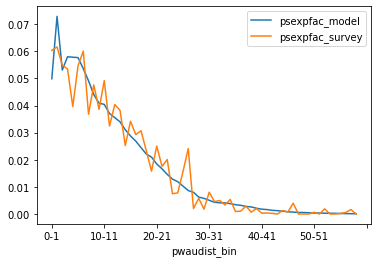

In [17]:
# Create bins
max_bin = 60
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='pwaudist_bin'>

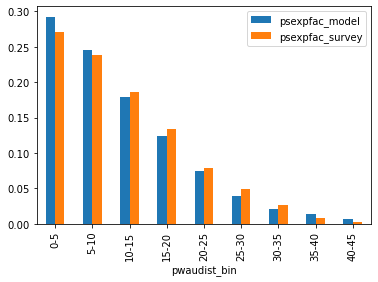

In [18]:
# Create bins
max_bin = 50
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

#### Trip Length Distribution - Pierce County

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='pwaudist_bin'>

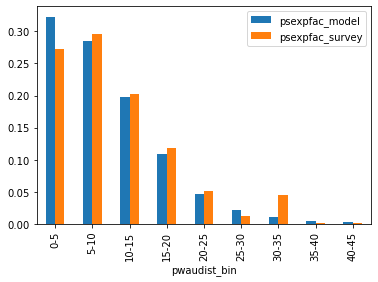

In [19]:
# Create bins
max_bin = 50
person1['pwaudist_bin'] = pd.cut(person1['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person1[(person1['source'] == 'model') & (person1['pwaudist'] <= max_bin) & (person1['pwaudist'] > 0)]
df2 = person1[(person1['source'] == 'survey') & (person1['pwaudist'] <= max_bin) & (person1['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

#### Trip Length Distribution - Other Counties

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='pwaudist_bin'>

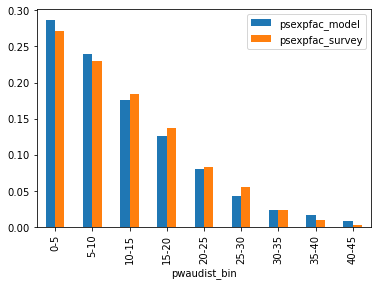

In [20]:
# Create bins
max_bin = 50
person2['pwaudist_bin'] = pd.cut(person2['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person2[(person2['source'] == 'model') & (person2['pwaudist'] <= max_bin) & (person2['pwaudist'] > 0)]
df2 = person2[(person2['source'] == 'survey') & (person2['pwaudist'] <= max_bin) & (person2['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### Percent of Workers with <1 Mile and >20 Mile Commutes

In [21]:
pd.options.display.float_format = '{:,.1%}'.format

_df_tot = person[person['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person[(person['pwaudist'] < 1) & (person['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person[(person['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,5.0%,6.0%
1,> 20 miles,16.2%,17.3%


<AxesSubplot:xlabel='Commute Range'>

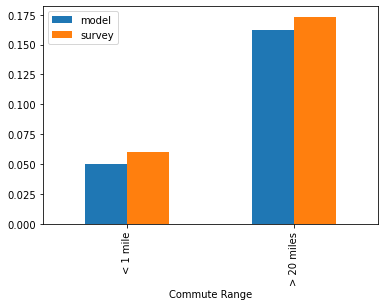

In [22]:
_df.set_index('Commute Range').plot(kind='bar',)

#### Percent of Workers with <1 Mile and >20 Mile Commutes - Pierce County

In [23]:
_df_tot = person1[person1['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person1[(person1['pwaudist'] < 1) & (person1['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person1[(person1['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,3.3%,7.0%
1,> 20 miles,8.7%,11.1%


<AxesSubplot:xlabel='Commute Range'>

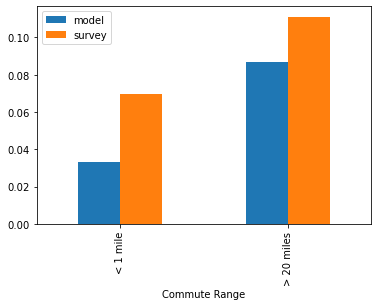

In [24]:
_df.set_index('Commute Range').plot(kind='bar',)

#### Percent of Workers with <1 Mile and >20 Mile Commutes - Other Counties

In [25]:
pd.options.display.float_format = '{:,.1%}'.format

_df_tot = person2[person2['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person2[(person2['pwaudist'] < 1) & (person2['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person2[(person2['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,5.3%,5.9%
1,> 20 miles,17.5%,18.3%


<AxesSubplot:xlabel='Commute Range'>

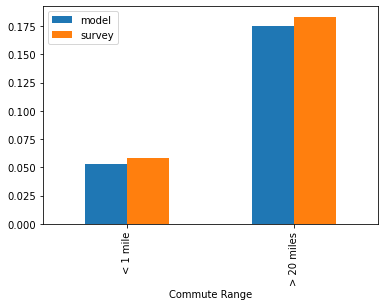

In [26]:
_df.set_index('Commute Range').plot(kind='bar',)

### Average Commute Distance by Gender

In [27]:
pd.options.display.float_format = '{:0,.2f}'.format
df = person[(person['pwaudist'] > 0) & (person['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,12.27,12.60
1,Female,10.31,10.47


<AxesSubplot:xlabel='Gender'>

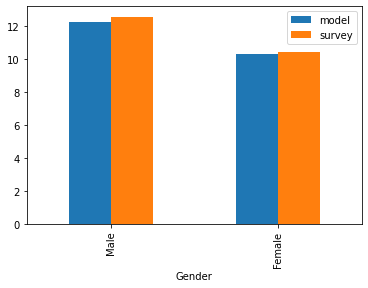

In [28]:
df.set_index('Gender').plot(kind='bar')

#### Average Commute Distance by Gender - Pierce County

In [29]:
df = person1[(person1['pwaudist'] > 0) & (person1['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,10.30,13.53
1,Female,8.78,7.06


<AxesSubplot:xlabel='Gender'>

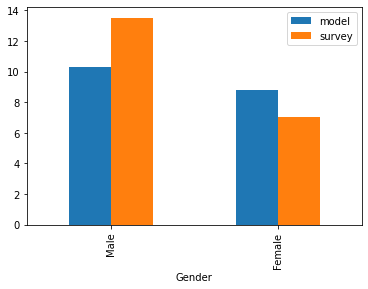

In [30]:
df.set_index('Gender').plot(kind='bar')

#### Average Commute Distance by Gender - Other Counties

In [31]:
df = person2[(person2['pwaudist'] > 0) & (person2['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,12.59,12.47
1,Female,10.59,11.12


<AxesSubplot:xlabel='Gender'>

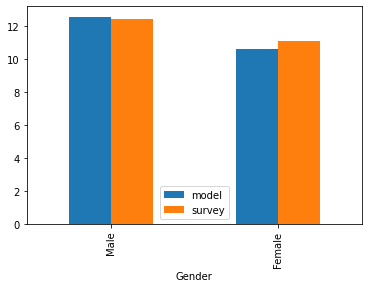

In [32]:
df.set_index('Gender').plot(kind='bar')

### Average Commute Distance by Age

In [33]:
person['age_cat'] = pd.cut(person['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person[(person['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Age Category,model,survey
0,<29,10.09,10.25
1,30-49,11.63,12.63
2,50-65,12.24,12.23
3,65+,11.10,9.61


<AxesSubplot:xlabel='Age Category'>

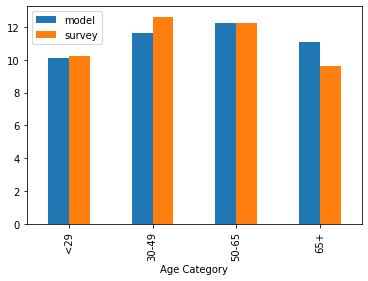

In [34]:
df.set_index('Age Category').plot(kind='bar')

#### Average Commute Distance by Age - Pierce County

In [35]:
person1['age_cat'] = pd.cut(person1['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person1[(person1['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Age Category,model,survey
0,<29,8.77,10.31
1,30-49,9.77,10.82
2,50-65,10.14,6.23
3,65+,9.30,6.71


<AxesSubplot:xlabel='Age Category'>

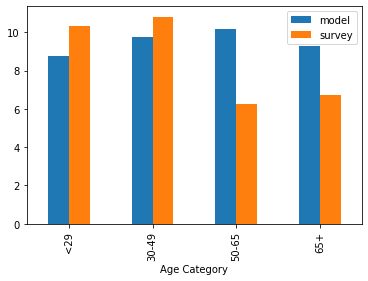

In [36]:
df.set_index('Age Category').plot(kind='bar')

#### Average Commute Distance by Age - Other Counties

In [37]:
person2['age_cat'] = pd.cut(person2['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person2[(person2['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

C:\Users\aditya.gore\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Age Category,model,survey
0,<29,10.34,10.24
1,30-49,11.94,12.96
2,50-65,12.59,12.86
3,65+,11.40,10.11


<AxesSubplot:xlabel='Age Category'>

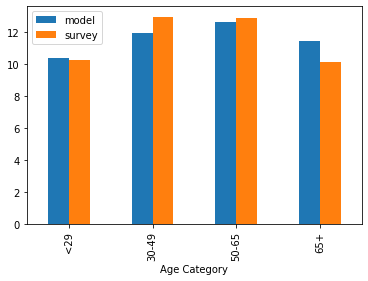

In [38]:
df.set_index('Age Category').plot(kind='bar')

## County to County Work Flows

All Workers

Model Results 

In [39]:
df = load_data(r'work_flows')
pd.options.display.float_format = '{:0,.0f}'.format
df.rename(columns={'person_county': 'Home County', 'person_work_county':'Work County'}, inplace=True)

df_model = pd.pivot_table(df[df['source'] == 'model'], index='Home County', columns='Work County', aggfunc='sum')
df_model['Total'] = df_model.sum(axis=1)
df_model.loc['Total',:] = df_model.sum(axis=0)
df_model

psexpfac                              Total
Work County      King Kitsap  Pierce Snohomish          
Home County                                             
King        1,024,328    428  27,573    38,242 1,090,571
Kitsap         10,092 92,532   6,834       121   109,579
Pierce         94,246  6,234 246,335       337   347,152
Snohomish     157,163    119     295   215,814   373,391
Total       1,285,829 99,313 281,037   254,514 1,920,693

Survey Results

In [40]:
df_survey = pd.pivot_table(df[df['source'] == 'survey'], index='Home County', columns='Work County', aggfunc='sum')
df_survey['Total'] = df_survey.sum(axis=1)
df_survey.loc['Total',:] = df_survey.sum(axis=0)
df_survey

psexpfac                              Total
Work County      King Kitsap  Pierce Snohomish          
Home County                                             
King          872,877    526  23,130    14,610   911,144
Kitsap         20,710 62,212   8,580       NaN    91,503
Pierce         65,276 10,745 220,524       NaN   296,546
Snohomish     122,381    NaN     NaN   197,237   319,618
Total       1,081,245 73,484 252,235   211,847 1,618,810

Total Difference (Model - Survey)

In [41]:
df_model-df_survey

psexpfac                           Total
Work County     King Kitsap Pierce Snohomish        
Home County                                         
King         151,451    -98  4,443    23,632 179,427
Kitsap       -10,618 30,320 -1,746       NaN  18,076
Pierce        28,970 -4,511 25,811       NaN  50,606
Snohomish     34,782    NaN    NaN    18,577  53,773
Total        204,584 25,829 28,802    42,667 301,883

Percent Difference (Relative to Survey)

In [42]:
((df_model-df_survey)/df_survey).applymap(format_percent)

psexpfac                               Total
Work County     King   Kitsap   Pierce Snohomish        
Home County                                             
King          17.35%  -18.63%   19.21%   161.75%  19.69%
Kitsap       -51.27%   48.74%  -20.35%      nan%  19.75%
Pierce        44.38%  -41.98%   11.70%      nan%  17.07%
Snohomish     28.42%     nan%     nan%     9.42%  16.82%
Total         18.92%   35.15%   11.42%    20.14%  18.65%